### Parsing `YCB` dataset

In [1]:
import mujoco
import numpy as np
import matplotlib.pyplot as plt
from mujoco_parser import MuJoCoParserClass
np.set_printoptions(precision=2,suppress=True,linewidth=100)
plt.rc('xtick',labelsize=6); plt.rc('ytick',labelsize=6)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("MuJoCo version:[%s]"%(mujoco.__version__))

MuJoCo version:[2.3.4]


### Parse `scene_ycb.xml`

In [2]:
# xml_path = './asset/scene_egad.xml'
xml_path = './asset/scene_ycb.xml'
env = MuJoCoParserClass(name='YCB dataset',rel_xml_path=xml_path,VERBOSE=True)
print ("[%s] parsed."%(env.name))

dt:[0.0020] HZ:[500]
n_body:[242]
geom_names:['floor', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, Non

In [3]:
from util import sample_xyzs

obj_names = ['adjustable_wrench','banana','baseball','bleach_cleanser','bowl','flat_screwdriver']
n_obj = len(obj_names)
# Place objects in a row
xyzs = sample_xyzs(n_sample=n_obj,
                   x_range=[0.45,1.65],y_range=[-0.3,0.3],z_range=[0.81,0.81],min_dist=0.2)

for obj_idx,obj_name in enumerate(obj_names):
    print(obj_name)
    jntadr = env.model.body(obj_name).jntadr[0]
    env.model.joint(jntadr).qpos0[:3] = xyzs[obj_idx,:]
    geomadr = env.model.body(obj_name).geomadr[0]

# Move tables and robot base
env.model.body('base_table').pos = np.array([0,0,0])
env.model.body('front_object_table').pos = np.array([1.05,0,0])
env.model.body('side_object_table').pos = np.array([0,-0.85,0])
env.model.body('base').pos = np.array([0,0,0.8])
print ("Ready.")

adjustable_wrench
banana
baseball
bleach_cleanser
bowl
flat_screwdriver
Ready.


In [4]:
env.open_interactive_viewer()

### Capture a image

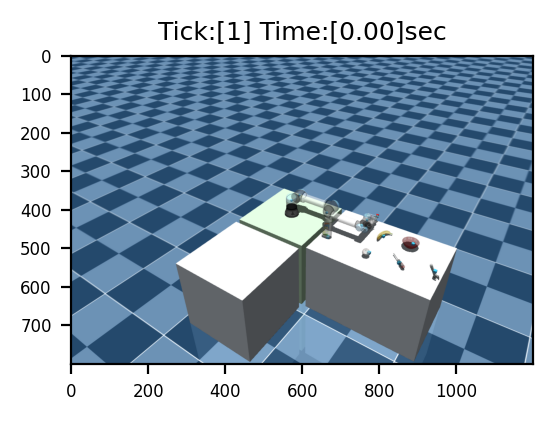

Pressed ESC
Quitting.


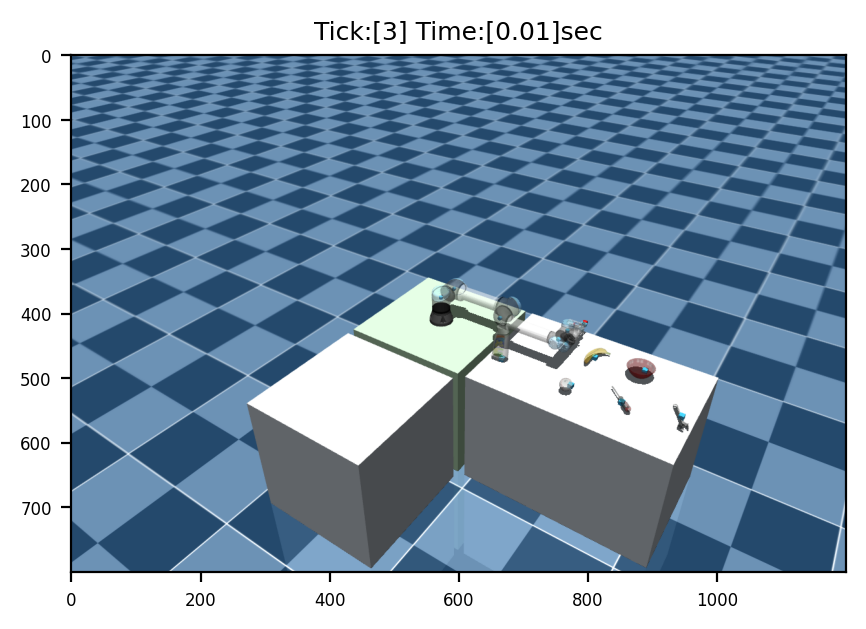

Done.


In [5]:
# Viewer
env.init_viewer(viewer_title='YCB dataset scene',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=124.08,distance=4.00,elevation=-33,lookat=[0.1,0.05,0.86],
                  VIS_TRANSPARENT=True,VIS_CONTACTPOINT=True,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=True,jointlength=0.2,jointwidth=0.05,jointrgba=[0.2,0.6,0.8,1.0])

# Loop
env.reset()
while (env.get_sim_time() < 100.0) and env.is_viewer_alive():
    env.step()
    env.render()
    # Plot
    if env.loop_every(HZ=2):    
        scene_img = env.grab_image()
        plt.figure(figsize=(3,2)); plt.imshow(scene_img)
        plt.title("Tick:[%d] Time:[%.2f]sec"%(env.tick,env.get_sim_time()),fontsize=9)
        plt.show()# Plot an image
plt.figure(figsize=(5,4)); plt.imshow(scene_img)
plt.title("Tick:[%d] Time:[%.2f]sec"%(env.tick,env.get_sim_time()),fontsize=9)
plt.show()
# Close viewer
env.close_viewer()
print ("Done.")

In [11]:
from util import sample_xyzs,rpy2r,r2rpy,compute_view_params,get_interp_const_vel_traj

# Init viewer
env.init_viewer(viewer_title='UR5e with RG2 gripper',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=66.08,distance=3.0,elevation=-50,lookat=[0.4,0.18,0.71],
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=False,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=False,jointlength=0.25,jointwidth=0.05,jointrgba=[0.2,0.6,0.8,0.6])

# Base pose
body_name = 'tcp_link'
p_base = env.get_p_body(body_name='base')

# Straight pose
DO_RENDER_IK = False
p_trgt = p_base + np.array([0.4,0,0.6])
R_trgt = rpy2r(np.radians([0,0,0]))@rpy2r(np.radians([-180,0,90]))
rev_joint_idxs = [0,1,2,3,4,5]
q_prepose_00 = env.solve_ik(
    body_name=body_name,p_trgt=p_trgt,R_trgt=R_trgt,IK_P=True,IK_R=True,
    q_init=np.radians([0,-90,0,0,0,0]),idxs_forward=env.idxs_forward, idxs_jacobian=env.idxs_jacobian,
    RESET=False,DO_RENDER=DO_RENDER_IK,render_every=10,th=1*np.pi/180.0,err_th=1e-2)

# 30 deg down pose
p_trgt = p_base + np.array([0.4,0,0.6])
R_trgt = rpy2r(np.radians([0,30,0]))@rpy2r(np.radians([-180,0,90]))
rev_joint_idxs = [0,1,2,3,4,5]
q_prepose_30 = env.solve_ik(
    body_name=body_name,p_trgt=p_trgt,R_trgt=R_trgt,IK_P=True,IK_R=True,
    q_init=q_prepose_00,idxs_forward=env.idxs_forward, idxs_jacobian=env.idxs_jacobian,
    RESET=False,DO_RENDER=DO_RENDER_IK,render_every=10,th=1*np.pi/180.0,err_th=1e-4)

# 60 deg down pose
p_trgt = p_base + np.array([0.4,0,0.6])
R_trgt = rpy2r(np.radians([0,60,0]))@rpy2r(np.radians([-180,0,90]))
rev_joint_idxs = [0,1,2,3,4,5]
q_prepose_60 = env.solve_ik(
    body_name=body_name,p_trgt=p_trgt,R_trgt=R_trgt,IK_P=True,IK_R=True,
    q_init=q_prepose_30,idxs_forward=env.idxs_forward, idxs_jacobian=env.idxs_jacobian,
    RESET=False,DO_RENDER=DO_RENDER_IK,render_every=10,th=1*np.pi/180.0,err_th=1e-4)

print ("IK done.")

# Get joint trajectory
times,q_traj = get_interp_const_vel_traj(
    np.vstack((q_prepose_60,q_prepose_30,q_prepose_00,q_prepose_30,q_prepose_60)),
    vel=np.radians(30),HZ=env.HZ)
print ("q_traj's L:[%d] time_max:[%.2f]sec"%(times.shape[0],times[-1]))

pcd_tick = 0

# Reset
env.reset()
env.forward(q=q_traj[0,:],joint_idxs=[0,1,2,3,4,5])
tick,max_sec = 0,100
while env.get_sim_time() <= max_sec:
    # Step
    q = np.append(q_traj[tick,:],1.0) # open gripper
    env.step(ctrl=q,ctrl_idxs=[0,1,2,3,4,5,6])
    tick = min(tick + 1,q_traj.shape[0]-1)
    if not env.is_viewer_alive(): break
        
    # Render
    if env.loop_every(HZ=20):
        pcd_tick += 1
        # Compute some poses
        p_tcp,R_tcp = env.get_pR_body(body_name='tcp_link')
        p_cam,R_cam = env.get_pR_body(body_name='camera_center')
        p_base,R_base = env.get_pR_body(body_name='base')
        # Get PCD from a specific view
        p_ego  = p_cam
        p_trgt = p_cam + R_cam[:,2]
        rgb_img,depth_img,pcd,xyz_img = env.get_egocentric_rgb_depth_pcd(
            p_ego=p_ego,p_trgt=p_trgt,rsz_rate=45,fovy=45,BACKUP_AND_RESTORE_VIEW=True)
        np.save('./data_2/pcd_%04d.npy'%(pcd_tick),pcd)
        # Render
        env.plot_T(p=p_cam,R=R_cam,PLOT_AXIS=True,axis_len=0.2,axis_width=0.005)
        # env.plot_T(p=p_base,R=R_base,PLOT_AXIS=True,axis_len=1.0,axis_width=0.01)
        # for p in pcd: env.plot_sphere(p=p,r=0.005,rgba=[0.95,0.05,0.05,1])
        # env.update_viewer(distance=2.0,lookat=p_cam) # update viewer
        env.render(render_every=1)
        
    # Plot
    # if env.loop_every(HZ=1):
    #     fig,axs = plt.subplots(1,3,figsize=(10,2))
    #     scene_img = env.grab_image()
    #     axs[0].imshow(scene_img); axs[1].imshow(rgb_img); axs[2].imshow(depth_img)
    #     fig.suptitle('tick:[%d] time:[%.2f]sec'%(env.tick,env.get_sim_time()),fontsize=11)
    #     plt.subplots_adjust(wspace=0.2); plt.show()
        
# Close viewer
env.close_viewer()
print ("Done. Tick:[%d] Time:[%.2f]sec"%(env.tick,env.get_sim_time()))

IK done.
q_traj's L:[2861] time_max:[5.72]sec
Pressed ESC
Quitting.
Done. Tick:[49652] Time:[99.30]sec
